In [ ]:
!pip install wget torchinfo
!wget -O NCT-CRC-HE-100K.zip https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
!unzip -qq NCT-CRC-HE-100K.zip -d train

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=08b65785b9d435e701ef17f881d87057fa1ef9592d844220a20c97eea1c8fd0d
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
--2025-01-19 12:28:30--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1214456/files/NCT-CRC-HE-100K.zip [following]
--2025-01-19 12:28:30--  https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip 100%[===================>]  

In [ ]:
!wget -O CRC-VAL-HE-7K.zip https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip
!unzip -qq CRC-VAL-HE-7K.zip -d val

--2025-01-19 12:41:59--  https://zenodo.org/records/1214456/files/CRC-VAL-HE-7K.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 800276929 (763M) [application/octet-stream]
Saving to: ‘CRC-VAL-HE-7K.zip’

CRC-VAL-HE-7K.zip   100%[===================>] 763.20M  12.0MB/s    in 67s     

2025-01-19 12:43:07 (11.3 MB/s) - ‘CRC-VAL-HE-7K.zip’ saved [800276929/800276929]



In [ ]:
!pip install torchinfo

import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary

In [ ]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [ ]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [ ]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [ ]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [ ]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [ ]:
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x

In [ ]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [ ]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x

In [ ]:
class LeViTDistilled(nn.Module):
    def __init__(self, num_classes=37):
        super(LeViTDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=2, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=2, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [ ]:
model = LeViTDistilled()
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 128
learning_rate = 1e-4
num_epochs = 75
weight_decay = 1e-5

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

LeViTDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [ ]:
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                                  Output Shape              Param #
HoViT                                                   [32, 37]                  --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─ConvNorm: 2-1                                    [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    └─Hardswish: 2-2                                   [32, 32, 112, 112]        --
│    └─ConvNorm: 2-3                                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-3                                 [32, 64, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-4                            [32, 64, 56, 56]          128
│    └─Hardswish: 2-4                                   [32, 64, 56, 56]          --
│    └─ConvNorm: 2-5                                  

In [ ]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                  Output Shape              Param #
HoViT                                                   [32, 37]                  --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias              

# Dataset setup
- NCT-CRC-HE-100K is for training only.
  - we split this into 7:1.5:1.5 ratio for train/val/test.
- CRC-VAL-HE-7K is for validation **after** the training is complete.

- If needed we perform augmentation to the NCT-CRC-HE-100K dataset.
  - Random flips, blur, noise, color/contrast adjustments are made.
  - When testing on 7k, we only flip the 7k dataset for evalutation.

In [ ]:
train_dir = './train/NCT-CRC-HE-100K'
val_dir = './val/CRC-VAL-HE-7K'

In [ ]:
class DataAugmentation:
    def __init__(self, p_hflip=0.5, p_vflip=0.5, p_noise=0.2, p_blur=0.2, p_color=0.2, p_contrast=0.2):
        self.p_hflip = p_hflip
        self.p_vflip = p_vflip
        self.p_noise = p_noise
        self.p_blur = p_blur
        self.p_color = p_color
        self.p_contrast = p_contrast

    def __call__(self, img):
        if random.random() < self.p_hflip:
            img = TF.hflip(img)

        if random.random() < self.p_vflip:
            img = TF.vflip(img)

        if random.random() < self.p_noise:
            noise = torch.randn(*img.size()) * 0.1
            img = torch.clamp(img + noise, 0, 1)

        if random.random() < self.p_blur:
            img = TF.gaussian_blur(img, kernel_size=(5, 5), sigma=(0.1, 5))

        if random.random() < self.p_color:
            img = TF.adjust_saturation(img, saturation_factor = random.uniform(0.5, 1.5))

        if random.random() < self.p_contrast:
            img = TF.adjust_contrast(img, contrast_factor = random.uniform(0.5, 1.5))

        return img

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    DataAugmentation(),
])

In [ ]:
train_set = datasets.ImageFolder(root=train_dir, transform=transform)

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from PIL import Image

from matplotlib import pyplot as plt

import random
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset


data_paths, labels = zip(*train_set.samples)
labels = np.array(labels)

# 7 : 3 split
train_idx, tmp_idx, _, tmp_labels = train_test_split(
    np.arange(len(labels)), labels, test_size=0.3, stratify=labels, random_state=42
)

# 3 -> 1.5 : 1.5 split
val_idx, test_idx = train_test_split(
    tmp_idx, test_size=0.5, stratify=tmp_labels, random_state=42
)

train_data = Subset(train_set, train_idx)
val_data = Subset(train_set, val_idx)
test_data = Subset(train_set, test_idx)

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 70000
Validation set size: 15000
Test set size: 15000


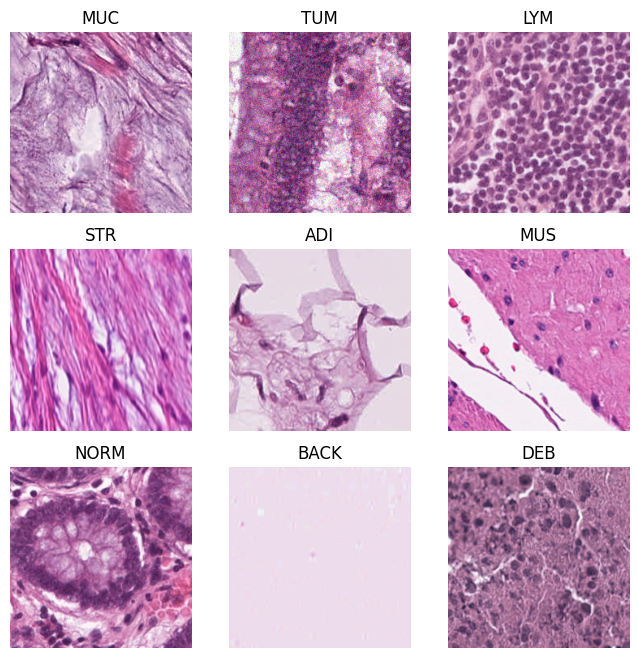

In [ ]:
# Show one example per class from the training dataset
import matplotlib.pyplot as plt

# Prepare a dictionary to store one example per class
class_examples = {}
for images, labels in train_loader:
    for img, label in zip(images, labels):
        label = label.item()
        if label not in class_examples:
            class_examples[label] = img
        # Stop if we already have one example for each class
        if len(class_examples) == len(train_set.classes):
            break
    if len(class_examples) == len(train_set.classes):
        break

# Display the images and their labels
figure = plt.figure(figsize=(8, 8))
cols = 3  # You can adjust the number of columns as needed
rows = (len(train_set.classes) + cols - 1) // cols  # Calculate required rows
for i, (label, img) in enumerate(class_examples.items(), start=1):
    figure.add_subplot(rows, cols, i)
    plt.title(train_set.classes[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).numpy())  # Convert tensor to numpy for display
plt.show()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [ ]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        scheduler.step()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)


In [ ]:
def evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

In [ ]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [ ]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="Validation")


Epoch 1/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.37it/s]


Train Loss: 0.8152, Train Accuracy: 72.37%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.85it/s]


Validation Loss: 0.5990, Validation Accuracy: 78.18%

Epoch 2/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.37it/s]


Train Loss: 0.4536, Train Accuracy: 83.97%


Validation: 100%|██████████| 118/118 [00:29<00:00,  3.96it/s]


Validation Loss: 0.3524, Validation Accuracy: 87.98%

Epoch 3/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.37it/s]


Train Loss: 0.3058, Train Accuracy: 89.21%


Validation: 100%|██████████| 118/118 [00:29<00:00,  3.98it/s]


Validation Loss: 0.2711, Validation Accuracy: 90.63%

Epoch 4/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.38it/s]


Train Loss: 0.2267, Train Accuracy: 92.09%


Validation: 100%|██████████| 118/118 [00:29<00:00,  3.95it/s]


Validation Loss: 0.2208, Validation Accuracy: 92.23%

Epoch 5/75


Training: 100%|██████████| 547/547 [02:41<00:00,  3.38it/s]


Train Loss: 0.1933, Train Accuracy: 93.07%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.92it/s]


Validation Loss: 0.2260, Validation Accuracy: 92.41%

Epoch 6/75


Training: 100%|██████████| 547/547 [02:41<00:00,  3.39it/s]


Train Loss: 0.1669, Train Accuracy: 94.15%


Validation: 100%|██████████| 118/118 [00:29<00:00,  3.95it/s]


Validation Loss: 0.2114, Validation Accuracy: 92.33%

Epoch 7/75


Training: 100%|██████████| 547/547 [02:41<00:00,  3.38it/s]


Train Loss: 0.1436, Train Accuracy: 94.96%


Validation: 100%|██████████| 118/118 [00:29<00:00,  3.94it/s]


Validation Loss: 0.2049, Validation Accuracy: 92.89%

Epoch 8/75


Training: 100%|██████████| 547/547 [02:41<00:00,  3.38it/s]


Train Loss: 0.1262, Train Accuracy: 95.57%


Validation: 100%|██████████| 118/118 [00:29<00:00,  3.95it/s]


Validation Loss: 0.1592, Validation Accuracy: 94.44%

Epoch 9/75


Training: 100%|██████████| 547/547 [02:41<00:00,  3.38it/s]


Train Loss: 0.1135, Train Accuracy: 96.04%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.93it/s]


Validation Loss: 0.1132, Validation Accuracy: 96.16%

Epoch 10/75


Training: 100%|██████████| 547/547 [02:41<00:00,  3.39it/s]


Train Loss: 0.1044, Train Accuracy: 96.33%


Validation: 100%|██████████| 118/118 [00:29<00:00,  3.94it/s]


Validation Loss: 0.1477, Validation Accuracy: 95.02%

Epoch 11/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.37it/s]


Train Loss: 0.0945, Train Accuracy: 96.65%


Validation: 100%|██████████| 118/118 [00:29<00:00,  3.94it/s]


Validation Loss: 0.0973, Validation Accuracy: 96.65%

Epoch 12/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.37it/s]


Train Loss: 0.0860, Train Accuracy: 96.97%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.92it/s]


Validation Loss: 0.1002, Validation Accuracy: 96.47%

Epoch 13/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.37it/s]


Train Loss: 0.0774, Train Accuracy: 97.27%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.92it/s]


Validation Loss: 0.1050, Validation Accuracy: 96.39%

Epoch 14/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.37it/s]


Train Loss: 0.0739, Train Accuracy: 97.45%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.93it/s]


Validation Loss: 0.0880, Validation Accuracy: 97.07%

Epoch 15/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.37it/s]


Train Loss: 0.0670, Train Accuracy: 97.72%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.92it/s]


Validation Loss: 0.0915, Validation Accuracy: 96.93%

Epoch 16/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.37it/s]


Train Loss: 0.0603, Train Accuracy: 97.91%


Validation: 100%|██████████| 118/118 [00:29<00:00,  3.97it/s]


Validation Loss: 0.0698, Validation Accuracy: 97.69%

Epoch 17/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.37it/s]


Train Loss: 0.0597, Train Accuracy: 97.99%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.91it/s]


Validation Loss: 0.0748, Validation Accuracy: 97.54%

Epoch 18/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.37it/s]


Train Loss: 0.0560, Train Accuracy: 98.05%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.91it/s]


Validation Loss: 0.0848, Validation Accuracy: 97.05%

Epoch 19/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.37it/s]


Train Loss: 0.0477, Train Accuracy: 98.37%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.91it/s]


Validation Loss: 0.0889, Validation Accuracy: 96.99%

Epoch 20/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.37it/s]


Train Loss: 0.0516, Train Accuracy: 98.16%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.93it/s]


Validation Loss: 0.0805, Validation Accuracy: 97.15%

Epoch 21/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.37it/s]


Train Loss: 0.0453, Train Accuracy: 98.44%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.91it/s]


Validation Loss: 0.0602, Validation Accuracy: 97.86%

Epoch 22/75


Training: 100%|██████████| 547/547 [02:43<00:00,  3.35it/s]


Train Loss: 0.0431, Train Accuracy: 98.50%


Validation: 100%|██████████| 118/118 [00:29<00:00,  3.95it/s]


Validation Loss: 0.0553, Validation Accuracy: 98.15%

Epoch 23/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.36it/s]


Train Loss: 0.0391, Train Accuracy: 98.68%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.91it/s]


Validation Loss: 0.0577, Validation Accuracy: 98.11%

Epoch 24/75


Training: 100%|██████████| 547/547 [02:41<00:00,  3.38it/s]


Train Loss: 0.0416, Train Accuracy: 98.55%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.92it/s]


Validation Loss: 0.0544, Validation Accuracy: 98.24%

Epoch 25/75


Training: 100%|██████████| 547/547 [02:41<00:00,  3.38it/s]


Train Loss: 0.0381, Train Accuracy: 98.69%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.92it/s]


Validation Loss: 0.1093, Validation Accuracy: 96.62%

Epoch 26/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.37it/s]


Train Loss: 0.0384, Train Accuracy: 98.69%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.90it/s]


Validation Loss: 0.0565, Validation Accuracy: 98.16%

Epoch 27/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.36it/s]


Train Loss: 0.0350, Train Accuracy: 98.75%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.92it/s]


Validation Loss: 0.0595, Validation Accuracy: 98.05%

Epoch 28/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.37it/s]


Train Loss: 0.0302, Train Accuracy: 98.95%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.92it/s]


Validation Loss: 0.0578, Validation Accuracy: 98.03%

Epoch 29/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.37it/s]


Train Loss: 0.0315, Train Accuracy: 98.90%


Validation: 100%|██████████| 118/118 [00:29<00:00,  3.96it/s]


Validation Loss: 0.0395, Validation Accuracy: 98.83%

Epoch 30/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.36it/s]


Train Loss: 0.0288, Train Accuracy: 99.01%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.91it/s]


Validation Loss: 0.0488, Validation Accuracy: 98.41%

Epoch 31/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.37it/s]


Train Loss: 0.0295, Train Accuracy: 98.95%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.91it/s]


Validation Loss: 0.0597, Validation Accuracy: 98.05%

Epoch 32/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.36it/s]


Train Loss: 0.0289, Train Accuracy: 99.02%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.91it/s]


Validation Loss: 0.0518, Validation Accuracy: 98.34%

Epoch 33/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.36it/s]


Train Loss: 0.0276, Train Accuracy: 99.07%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.93it/s]


Validation Loss: 0.0643, Validation Accuracy: 98.02%

Epoch 34/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.36it/s]


Train Loss: 0.0271, Train Accuracy: 99.07%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.91it/s]


Validation Loss: 0.0589, Validation Accuracy: 98.16%

Epoch 35/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.36it/s]


Train Loss: 0.0251, Train Accuracy: 99.16%


Validation: 100%|██████████| 118/118 [00:29<00:00,  3.94it/s]


Validation Loss: 0.0398, Validation Accuracy: 98.59%

Epoch 36/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.37it/s]


Train Loss: 0.0240, Train Accuracy: 99.15%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.93it/s]


Validation Loss: 0.0441, Validation Accuracy: 98.53%

Epoch 37/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.36it/s]


Train Loss: 0.0204, Train Accuracy: 99.29%


Validation: 100%|██████████| 118/118 [00:29<00:00,  3.94it/s]


Validation Loss: 0.0692, Validation Accuracy: 97.82%

Epoch 38/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.37it/s]


Train Loss: 0.0226, Train Accuracy: 99.23%


Validation: 100%|██████████| 118/118 [00:29<00:00,  3.94it/s]


Validation Loss: 0.0520, Validation Accuracy: 98.44%

Epoch 39/75


Training: 100%|██████████| 547/547 [02:42<00:00,  3.36it/s]


Train Loss: 0.0238, Train Accuracy: 99.16%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.92it/s]


Validation Loss: 0.0518, Validation Accuracy: 98.39%

Epoch 40/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.26it/s]


Train Loss: 0.0204, Train Accuracy: 99.34%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.70it/s]


Validation Loss: 0.0680, Validation Accuracy: 97.95%

Epoch 41/75


Training: 100%|██████████| 547/547 [02:51<00:00,  3.19it/s]


Train Loss: 0.0219, Train Accuracy: 99.25%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.73it/s]


Validation Loss: 0.0483, Validation Accuracy: 98.45%

Epoch 42/75


Training: 100%|██████████| 547/547 [02:51<00:00,  3.19it/s]


Train Loss: 0.0202, Train Accuracy: 99.31%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.69it/s]


Validation Loss: 0.0381, Validation Accuracy: 98.75%

Epoch 43/75


Training: 100%|██████████| 547/547 [02:51<00:00,  3.20it/s]


Train Loss: 0.0199, Train Accuracy: 99.31%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.70it/s]


Validation Loss: 0.0598, Validation Accuracy: 98.22%

Epoch 44/75


Training: 100%|██████████| 547/547 [02:51<00:00,  3.20it/s]


Train Loss: 0.0199, Train Accuracy: 99.34%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.70it/s]


Validation Loss: 0.0606, Validation Accuracy: 98.32%

Epoch 45/75


Training: 100%|██████████| 547/547 [02:50<00:00,  3.20it/s]


Train Loss: 0.0177, Train Accuracy: 99.39%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.71it/s]


Validation Loss: 0.0552, Validation Accuracy: 98.26%

Epoch 46/75


Training: 100%|██████████| 547/547 [02:50<00:00,  3.21it/s]


Train Loss: 0.0187, Train Accuracy: 99.36%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.74it/s]


Validation Loss: 0.0613, Validation Accuracy: 98.11%

Epoch 47/75


Training: 100%|██████████| 547/547 [02:51<00:00,  3.19it/s]


Train Loss: 0.0203, Train Accuracy: 99.30%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.72it/s]


Validation Loss: 0.0461, Validation Accuracy: 98.68%

Epoch 48/75


Training: 100%|██████████| 547/547 [02:50<00:00,  3.20it/s]


Train Loss: 0.0167, Train Accuracy: 99.45%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.70it/s]


Validation Loss: 0.0421, Validation Accuracy: 98.65%

Epoch 49/75


Training: 100%|██████████| 547/547 [02:56<00:00,  3.10it/s]


Train Loss: 0.0171, Train Accuracy: 99.40%


Validation: 100%|██████████| 118/118 [00:47<00:00,  2.48it/s]


Validation Loss: 0.0541, Validation Accuracy: 98.23%

Epoch 50/75


Training: 100%|██████████| 547/547 [02:56<00:00,  3.09it/s]


Train Loss: 0.0171, Train Accuracy: 99.40%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.75it/s]


Validation Loss: 0.0427, Validation Accuracy: 98.63%

Epoch 51/75


Training: 100%|██████████| 547/547 [02:48<00:00,  3.25it/s]


Train Loss: 0.0148, Train Accuracy: 99.48%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.81it/s]


Validation Loss: 0.0528, Validation Accuracy: 98.39%

Epoch 52/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.27it/s]


Train Loss: 0.0184, Train Accuracy: 99.38%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.80it/s]


Validation Loss: 0.0479, Validation Accuracy: 98.39%

Epoch 53/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.27it/s]


Train Loss: 0.0161, Train Accuracy: 99.47%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.81it/s]


Validation Loss: 0.0432, Validation Accuracy: 98.65%

Epoch 54/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.27it/s]


Train Loss: 0.0139, Train Accuracy: 99.52%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.78it/s]


Validation Loss: 0.0492, Validation Accuracy: 98.57%

Epoch 55/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.26it/s]


Train Loss: 0.0160, Train Accuracy: 99.46%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.78it/s]


Validation Loss: 0.0708, Validation Accuracy: 97.73%

Epoch 56/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.27it/s]


Train Loss: 0.0139, Train Accuracy: 99.57%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.82it/s]


Validation Loss: 0.0432, Validation Accuracy: 98.70%

Epoch 57/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.27it/s]


Train Loss: 0.0151, Train Accuracy: 99.49%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.80it/s]


Validation Loss: 0.0484, Validation Accuracy: 98.57%

Epoch 58/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.26it/s]


Train Loss: 0.0151, Train Accuracy: 99.50%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.79it/s]


Validation Loss: 0.0493, Validation Accuracy: 98.69%

Epoch 59/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.26it/s]


Train Loss: 0.0135, Train Accuracy: 99.52%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.81it/s]


Validation Loss: 0.0396, Validation Accuracy: 98.87%

Epoch 60/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.27it/s]


Train Loss: 0.0140, Train Accuracy: 99.51%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.79it/s]


Validation Loss: 0.0409, Validation Accuracy: 98.81%

Epoch 61/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.27it/s]


Train Loss: 0.0128, Train Accuracy: 99.58%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.81it/s]


Validation Loss: 0.0507, Validation Accuracy: 98.55%

Epoch 62/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.26it/s]


Train Loss: 0.0150, Train Accuracy: 99.46%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.76it/s]


Validation Loss: 0.0463, Validation Accuracy: 98.51%

Epoch 63/75


Training: 100%|██████████| 547/547 [02:46<00:00,  3.28it/s]


Train Loss: 0.0128, Train Accuracy: 99.56%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.79it/s]


Validation Loss: 0.0381, Validation Accuracy: 98.75%

Epoch 64/75


Training: 100%|██████████| 547/547 [02:48<00:00,  3.25it/s]


Train Loss: 0.0129, Train Accuracy: 99.53%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.81it/s]


Validation Loss: 0.0370, Validation Accuracy: 98.94%

Epoch 65/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.27it/s]


Train Loss: 0.0137, Train Accuracy: 99.53%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.77it/s]


Validation Loss: 0.0321, Validation Accuracy: 99.03%

Epoch 66/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.27it/s]


Train Loss: 0.0118, Train Accuracy: 99.59%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.81it/s]


Validation Loss: 0.0365, Validation Accuracy: 98.91%

Epoch 67/75


Training: 100%|██████████| 547/547 [02:46<00:00,  3.28it/s]


Train Loss: 0.0115, Train Accuracy: 99.62%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.78it/s]


Validation Loss: 0.0463, Validation Accuracy: 98.59%

Epoch 68/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.27it/s]


Train Loss: 0.0147, Train Accuracy: 99.52%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.76it/s]


Validation Loss: 0.0391, Validation Accuracy: 98.84%

Epoch 69/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.26it/s]


Train Loss: 0.0105, Train Accuracy: 99.61%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.80it/s]


Validation Loss: 0.0396, Validation Accuracy: 98.81%

Epoch 70/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.27it/s]


Train Loss: 0.0110, Train Accuracy: 99.65%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.78it/s]


Validation Loss: 0.0646, Validation Accuracy: 98.30%

Epoch 71/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.27it/s]


Train Loss: 0.0131, Train Accuracy: 99.54%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.78it/s]


Validation Loss: 0.0311, Validation Accuracy: 98.91%

Epoch 72/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.26it/s]


Train Loss: 0.0118, Train Accuracy: 99.61%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.81it/s]


Validation Loss: 0.0380, Validation Accuracy: 98.83%

Epoch 73/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.26it/s]


Train Loss: 0.0102, Train Accuracy: 99.67%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.81it/s]


Validation Loss: 0.0393, Validation Accuracy: 98.91%

Epoch 74/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.26it/s]


Train Loss: 0.0116, Train Accuracy: 99.62%


Validation: 100%|██████████| 118/118 [00:31<00:00,  3.78it/s]


Validation Loss: 0.0372, Validation Accuracy: 98.93%

Epoch 75/75


Training: 100%|██████████| 547/547 [02:47<00:00,  3.26it/s]


Train Loss: 0.0120, Train Accuracy: 99.58%


Validation: 100%|██████████| 118/118 [00:30<00:00,  3.84it/s]

Validation Loss: 0.0317, Validation Accuracy: 99.07%


In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'epochs' is not defined

In [ ]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 118
Average Time: 15.16 ms
Standard Deviation: 0.85 ms
Maximum Time: 15.47 ms
Minimum Time: 5.96 ms


In [ ]:
evaluate(model, test_loader, criterion, device)

Validation: 100%|██████████| 118/118 [00:31<00:00,  3.72it/s]

Validation Loss: 0.0308, Validation Accuracy: 99.11%


In [ ]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul         1.94%     304.896us        19.97%       3.133ms     130.560us       0.000us         0.00%       2.539ms     105.773us            24  
                                           aten::linear         0.55%      85.663us        14.67%       2.301ms     127.843us       0.000us         0.00%       1.834ms     101.872us            18  
         

In [ ]:
save_path = "HoViT_NCT_augmentation_batch_128_scheduler_cosineAnnealing.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to HoViT_NCT_augmentation_batch_128_scheduler_cosineAnnealing.pth


In [ ]:
val_dir = "./val/CRC-VAL-HE-7K/"

# 변환 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    #DataAugmentation(),
])

# 데이터셋 로드
full_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score
import matplotlib.pyplot as plt

def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []
    val_accuracies = []
    val_losses = []
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

In [ ]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, full_loader, criterion, device)


Validation: 100%|██████████| 57/57 [00:11<00:00,  4.99it/s]

Validation Loss: 0.4448, Validation Accuracy: 91.49%
Overall - F1: 0.8943, Recall: 0.9038, Precision: 0.8957
Per-Class Metrics:
Class 0 - F1: 0.9398, Recall: 0.8931, Precision: 0.9917
Class 1 - F1: 0.9803, Recall: 1.0000, Precision: 0.9614
Class 2 - F1: 0.8209, Recall: 0.9735, Precision: 0.7097
Class 3 - F1: 0.9687, Recall: 1.0000, Precision: 0.9393
Class 4 - F1: 0.9177, Recall: 0.9324, Precision: 0.9036
Class 5 - F1: 0.8297, Recall: 0.8108, Precision: 0.8496
Class 6 - F1: 0.9002, Recall: 0.9555, Precision: 0.8510
Class 7 - F1: 0.7503, Recall: 0.6461, Precision: 0.8947
Class 8 - F1: 0.9413, Recall: 0.9230, Precision: 0.9603


<Figure size 2000x1200 with 0 Axes>

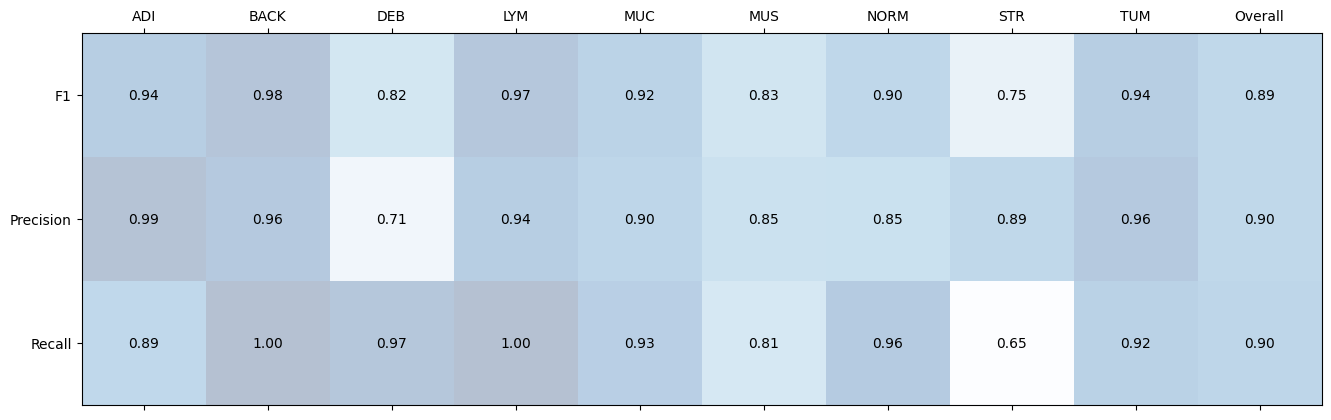

In [ ]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )